In [1]:
import datetime
import itertools
from os import path
import time

import ads
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm

I'm interested in how the popuarity of various programming languages and packages change with time, as measured by mentions in the astronomical literature. To answer this, I'm going to use the [`ads`](https://ads.readthedocs.io/en/latest/) package to query the "astronomy" database API at the [ADS](https://ui.adsabs.harvard.edu/) to search for full-text mentions of the words:
* Python
* Astropy
* IDL
* Matlab

We're going to construct a bunch of queries to get the number of articles that reference these terms per month since early 1991 (Python was released in February 1991). Let's first define a grid of year-month combinations to query on:

In [2]:
# Python was created: 20 February 1991
years = range(1991, 2018 + 1, 1)
months = range(1, 12 + 1, 1)
dates = [
    (y, m)
    for y, m in itertools.product(years, months)
    if y < 2018 or (y == 2018 and m < 3)
][
    1:
]  # start from Feb 1991

ndates = len(dates)
print(f"{ndates} queries to ADS in total")
print(dates[0], dates[-1])

325 queries to ADS in total
(1991, 2) (2018, 2)


So for each term, we will do 325 queries (!) to get the number of articles that mention the term for each month from Feb. 1991 to Feb. 2018. We won't want to repeat these queries (we'll start to hit rate limit issues for querying ADS), so I'll define a function that caches the results and returns the cached data if available. We'll collect the date-count information into a Pandas `DataFrame` and cache to disk as a CSV file:

In [3]:
def get_df(term, db, dates, overwrite=False, sleep=0.1):
    cache_file = "{0}_{1}.csv".format(term, db)
    ndates = len(dates)
    q = 'full:"{term:s}"  pubdate:{y:d}-{m:02d} database:"{db:s}"'

    if not path.exists(cache_file) or overwrite:
        df = pd.DataFrame(
            {
                "date": np.full(ndates, datetime.date(1984, 1, 1)),
                "count": np.full(ndates, -1),
            }
        )
        df.to_csv(cache_file, index=False)

    df = pd.read_csv(cache_file)
    d = df.to_dict()

    search = None
    if not np.all(df["count"] >= 0):
        for i, (y, m) in tqdm(enumerate(dates)):

            if d["count"][i] >= 0:
                continue

            search = ads.SearchQuery(q=q.format(y=y, m=m, term=term, db=db), rows=1000)
            d["count"][i] = len(list(search))
            d["date"][i] = datetime.date(y, m, 1)

            time.sleep(sleep)

    if search is not None and search.response is not None:
        nremain = search.response.get_ratelimits()["remaining"]
        print("{0} queries remaining".format(nremain))

    df = pd.DataFrame(d)
    df.to_csv(cache_file, index=False)
    df["date"] = pd.to_datetime(df["date"])

    return df

In [4]:
py_astro = get_df("python", "astronomy", dates)

325it [01:31,  3.57it/s]

4425 queries remaining


In [5]:
astropy_astro = get_df("astropy", "astronomy", dates)

325it [01:10,  4.62it/s]

4100 queries remaining


In [6]:
idl_astro = get_df("idl", "astronomy", dates)

325it [01:39,  3.28it/s]

3775 queries remaining


In [7]:
matlab_astro = get_df("matlab", "astronomy", dates)

325it [01:19,  4.09it/s]

3450 queries remaining


Let's first look at the popularity of these terms by year:

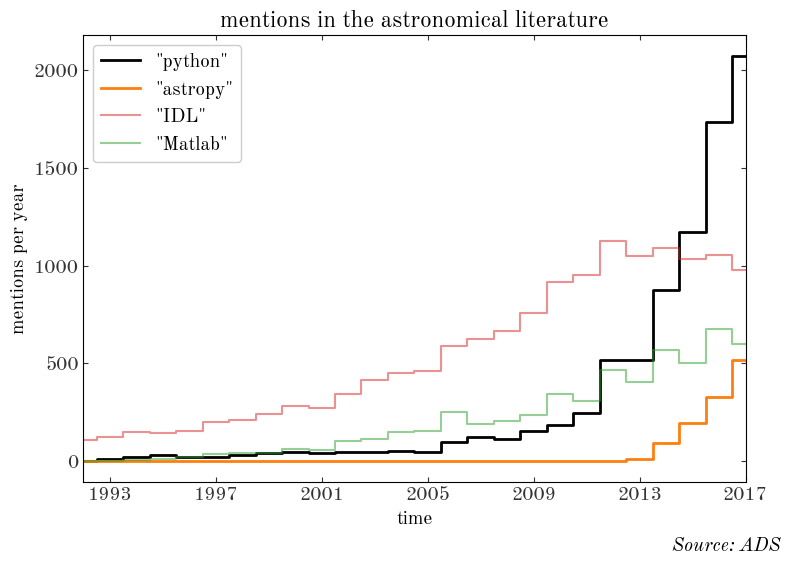

In [8]:
dfs = [py_astro, astropy_astro, idl_astro, matlab_astro]
labels = ['"python"', '"astropy"', '"IDL"', '"Matlab"']
styles = [
    dict(lw=2),
    dict(color="tab:orange", lw=2),
    dict(color="tab:red", alpha=0.5),
    dict(color="tab:green", alpha=0.5),
]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for df, label, style in zip(dfs, labels, styles):
    grouped = df.groupby(df["date"].map(lambda t: t.year)).sum()
    ax.plot(
        grouped.index,
        grouped["count"],
        marker="",
        drawstyle="steps-mid",
        label=label,
        **style
    )

ax.legend(loc="upper left", fontsize=14, framealpha=1)

ax.set_xlim(1992, 2017)
ax.xaxis.set_ticks(np.arange(1993, 2017 + 1, 4))

ax.set_xlabel("time")
ax.set_ylabel("mentions per year")
fig.suptitle("Source: ADS", y=0.02, x=0.99, fontsize=14, fontstyle="italic", ha="right")
fig.set_facecolor("w")

ax.set_title("mentions in the astronomical literature")

fig.tight_layout()

We can also look at smaller-scale behavior, since we have the data on a monthly basis. The next plot shows the number of "Python" mentions per month vs. time, with vertical lines over-plotted for past [ADASS](http://www.adass.org/) and SPIE instrumentation meetings:

In [9]:
adass = [
    (1991, 11, 6),
    (1992, 11, 2),
    (1993, 10, 13),
    (1994, 9, 26),
    (1995, 10, 22),
    (1996, 9, 22),
    (1997, 9, 14),
    (1998, 11, 1),
    (1999, 10, 3),
    (2000, 11, 12),
    (2001, 9, 30),
    (2002, 10, 13),
    (2003, 10, 12),
    (2004, 10, 24),
    (2005, 10, 2),
    (2006, 10, 15),
    (2007, 9, 23),
    (2008, 11, 2),
    (2009, 10, 4),
    (2010, 11, 7),
    (2011, 11, 6),
    (2012, 11, 4),
    (2013, 9, 29),
    (2014, 10, 5),
    (2015, 10, 25),
    (2016, 10, 16),
    (2017, 10, 22),
]

spie = [(2012, 8, 1), (2014, 6, 1), (2016, 6, 1)]

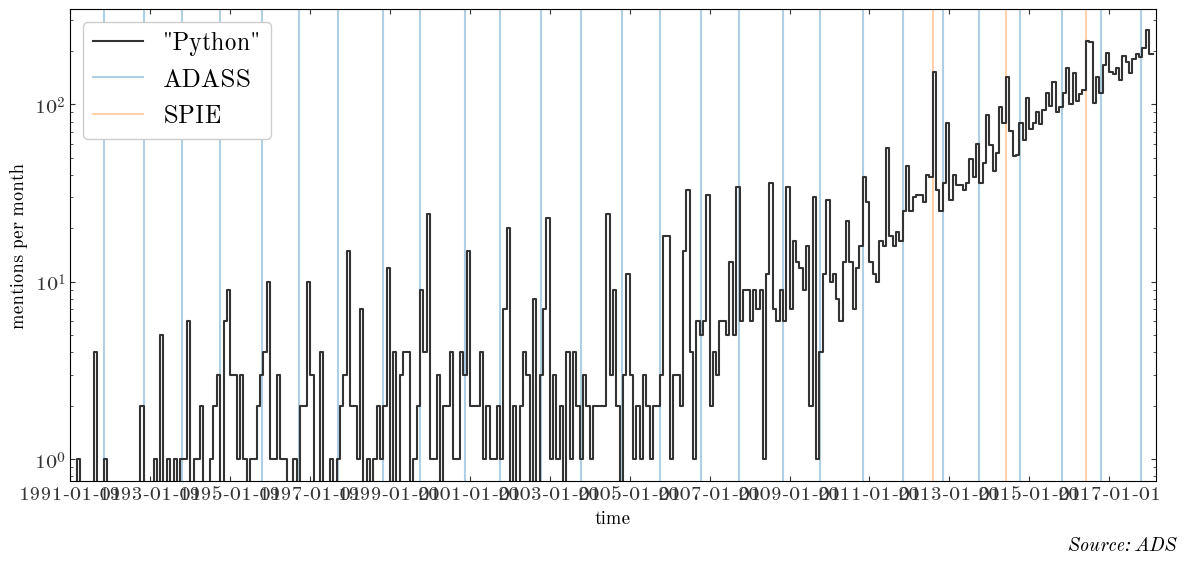

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(
    py_astro["date"],
    py_astro["count"],
    label='"Python"',
    drawstyle="steps-pre",
    marker="",
    color="#333333",
)

for i, stuff in enumerate(adass):
    kw = dict()
    if i == 0:
        kw = dict(label="ADASS")
    ax.axvline(
        datetime.date(*stuff),
        linestyle="-",
        marker="",
        zorder=-100,
        color="tab:blue",
        alpha=0.35,
        **kw
    )

for i, stuff in enumerate(spie):
    kw = dict()
    if i == 0:
        kw = dict(label="SPIE")
    ax.axvline(
        datetime.date(*stuff),
        linestyle="-",
        marker="",
        zorder=-100,
        color="tab:orange",
        alpha=0.35,
        **kw
    )

ax.legend(loc="upper left", fontsize=18, framealpha=1)

ax.set_yscale("log")

ax.xaxis.set_ticks([datetime.date(x, 1, 1) for x in range(1991, 2018 + 1, 2)])
ax.set_xlim(datetime.date(1991, 1, 1), datetime.date(2018, 3, 1))

ax.set_xlabel("time")
ax.set_ylabel("mentions per month")

fig.suptitle("Source: ADS", y=0.02, x=0.99, fontsize=14, fontstyle="italic", ha="right")

fig.set_facecolor("w")

fig.tight_layout()

The conference proceedings for both ADASS and SPIE show up as spikes in the number of articles that mention Python! But in recent times (>2014) those signals are becoming increasingly swamped by normal journal articles.